In [1]:
# imports 
import numpy as np 
import pandas as pd 
import statsmodels.api as sm
import h5_utilities_module as h5u
import matplotlib.pyplot as plt
from copy import deepcopy
from tqdm import tqdm
from pathlib import Path
import pingouin as pg
import warnings
from scipy.stats import zscore
import matplotlib.gridspec as gridspec
import statsmodels.api as sm
from statsmodels.formula.api import ols
warnings.filterwarnings("ignore", message="Mean of empty slice", category=RuntimeWarning)

In [2]:
def find_candidate_states(indata, n_classes, temporal_thresh, mag_thresh):
    """Finds periods where decoded posteriors are twice their noise level.

    Args:
        indata (ndarray): 2d array of posterior probabilities associated with some decoder output.
        n_classes (int): How many classes were used in the decoder?
        temporal_thresh (int): Number of contiguous samples that must be above a threshold to be a real state (typically 2).
        mag_thresh (flat): how many times the noise level must a state be? (e.g. 2 = twice the noise level)

    Returns:
        state_details (ndarray): 2d array where each row details when a state occurred [trial_num, time_in_trial, state_length, state_magnitude].
        state_array (ndarray): 2d array the same size as indata. It contains 1 in all locations where there were states and 0s everywhere else.
    """
    state_details = np.array([])
    state_array = np.zeros_like(indata)
    
    state_magnitude_thresh = (1 / n_classes) * mag_thresh

    for t in range(indata.shape[0]):
        state_len, state_pos, state_type = find_1dsequences(indata[t, :] > state_magnitude_thresh)
        state_len = state_len[state_type == True]
        state_pos = state_pos[state_type == True]

        for i in range(len(state_len)):
            state_details = np.concatenate((state_details, np.array([t, state_pos[i], state_len[i]])))

    state_details = state_details.reshape(-1, 3)
    state_details = state_details[state_details[:, 2] > temporal_thresh, :]

    # Update state_array using state_details information
    for j in range(len(state_details)):
        state_trial, state_start, state_len = state_details[j].astype(int)
        state_array[state_trial, state_start:(state_start + state_len)] = 1
        
    new_state_details = get_state_magnitudes(state_details, indata)

    return new_state_details, state_array


def get_state_magnitudes(state_details, indata):
    """This is a helpfer function for find_candidate_states that computes the magnitude of each candidate state. 

    Args:
        state_details (ndarray): 2d array where each row details when a state occurred [trial_num, time_in_trial, state_length].
        indata (ndarray): 2d array of posterior probabilities associated with some decoder output.

    Returns:
        new_state_details (ndarray): 2d array where each row details when a state occurred [trial_num, time_in_trial, state_length, state_magnitude].
    """
    
    new_state_details = np.zeros((len(state_details), 4))
    
    # loop over each state
    for i in range(len(state_details)):
        
        # pull the details of this particular state
        i_trial_num = int(state_details[i, 0])
        i_start_ix = int(state_details[i, 1])
        i_duration = int(state_details[i, 2])
        
        new_state_details[i, 0] = i_trial_num
        new_state_details[i, 1] = i_start_ix
        new_state_details[i, 2] = i_duration

        new_state_details[i, 3] = np.nanmean(indata[i_trial_num, i_start_ix:i_start_ix+i_duration])
        
    return new_state_details
        

def find_1dsequences(inarray):
        ''' 
        run length encoding. Partial credit to R rle function. 
        Multi datatype arrays catered for including non Numpy
        returns: tuple (runlengths, startpositions, values) 
        '''
        ia = np.asarray(inarray)                # force numpy
        n = len(ia)
        if n == 0: 
            return (None, None, None)
        else:
            y = ia[1:] != ia[:-1]                 # pairwise unequal (string safe)
            i = np.append(np.where(y), n - 1)     # must include last element 
            lens = np.diff(np.append(-1, i))      # run lengths
            pos = np.cumsum(np.append(0, lens))[:-1] # positions
            return(lens, pos, ia[i])
        
def moving_average(x, w, axis=0):
    '''
    Moving average function that operates along specified dimensions of a NumPy array.

    Parameters:
    - x (numpy.ndarray): Input array.
    - w (int): Size of the window to convolve the array with (i.e., smoothness factor).
    - axis (int): Axis along which to perform the moving average (default is 0).

    Returns:
    - numpy.ndarray: Smoothed array along the specified axis with the same size as the input array.
    '''
    x = np.asarray(x)  # Ensure input is a NumPy array
    if np.isnan(x).any():
        x = np.nan_to_num(x)  # Replace NaN values with zeros

    if axis < 0:
        axis += x.ndim  # Adjust negative axis value

    kernel = np.ones(w) / w  # Create kernel for moving average

    # Pad the array before applying convolution
    pad_width = [(0, 0)] * x.ndim  # Initialize padding for each axis
    pad_width[axis] = (w - 1, 0)  # Pad along the specified axis (left side)
    x_padded = np.pad(x, pad_width, mode='constant', constant_values=0)

    # Apply 1D convolution along the specified axis on the padded array
    return np.apply_along_axis(lambda m: np.convolve(m, kernel, mode='valid'), axis, x_padded)

def calculate_mean_and_interval(data, type='sem', num_samples=1000, alpha=0.05):
    """
    Calculate mean and either SEM or bootstrapped CI for input array, disregarding NaN values.
    Works with both 1D and 2D arrays.
    """
    # Ensure data is 2D
    data = np.asarray(data)
    if data.ndim == 1:
        data = data.reshape(-1, 1)
    
    nan_mask = ~np.isnan(data)
    nanmean_result = np.nanmean(data, axis=0)
    n_valid_values = np.sum(nan_mask, axis=0)
    
    if type == 'sem':
        nanstd_result = np.nanstd(data, axis=0)
        interval = nanstd_result / np.sqrt(n_valid_values)
        
    elif type == 'percentile':
        interval = np.nanmean(np.array([
            np.abs(nanmean_result - np.nanpercentile(data, 5, axis=0)),
            np.abs(nanmean_result - np.nanpercentile(data, 95, axis=0))
        ]))
        
    elif type == 'bootstrap':
        n_rows = data.shape[0]
        n_cols = data.shape[1]
        bootstrap_means = np.zeros((num_samples, n_cols))

        for col in range(n_cols):
            valid_data = data[:, col][nan_mask[:, col]]
            if len(valid_data) > 0:
                bootstrap_samples = np.random.choice(valid_data, size=(num_samples, n_rows), replace=True)
                bootstrap_means[:, col] = np.nanmean(bootstrap_samples, axis=1)
            else:
                bootstrap_means[:, col] = np.nan

        ci_lower = np.percentile(bootstrap_means, 100 * (alpha / 2), axis=0)
        ci_upper = np.percentile(bootstrap_means, 100 * (1 - alpha / 2), axis=0)
        interval = np.nanmean([
            abs(bootstrap_means - ci_lower),
            abs(bootstrap_means - ci_upper)
        ], axis=0)
        interval = np.nanmean(interval, axis=0)

    else:
        raise ValueError("Invalid 'type' argument. Use 'sem', 'percentile', or 'bootstrap'.")
    
    # Properly handle scalar output
    if data.shape[1] == 1:
        nanmean_result = float(nanmean_result[0])  # explicitly convert to float scalar
        if not np.isscalar(interval):
            interval = float(interval[0])  # explicitly convert to float scalar
    
    return nanmean_result, interval

def random_prop_of_array(inarray, proportion):
    '''
    INPUTS
    inarray = logical/boolean array of indices to potentially use later
    proportion = how much of inarray should randomly be selected

    OUTPUT
    out_array = logical/boolean that's set as 'true' for a proportion of the 
                initial 'true' values in inarray
    '''

    out_array = np.zeros(shape = (len(inarray), ))

    # find where inarray is true and shuffle those indices
    shuffled_ixs = np.random.permutation(np.asarray(np.where(inarray)).flatten())

    # keep only a proportion of that array
    kept_ix = shuffled_ixs[0: round(len(shuffled_ixs)*proportion)]

    # fill in the kept indices
    out_array[kept_ix] = 1

    # make this a logical/boolean
    out_array = out_array > 0

    return out_array


In [3]:
data_dir = 'C:/Users/thome/Documents/PYTHON/OFC-CdN 3 state self control/lfp_PSDs_Coh'
decoder_dir ='C:/Users/thome/Documents/PYTHON/OFC-CdN 3 state self control/decoder_output/'

# get their relevant paths
data_files = h5u.find_h5_files(data_dir)
decoder_files = h5u.find_h5_files(decoder_dir)
h5u.list_hdf5_data(data_files[0])

Datasets in 'C:/Users/thome/Documents/PYTHON/OFC-CdN 3 state self control/lfp_PSDs_Coh\D20231219_Rec05_psd_coh.h5':
amp_x_corr_lags
bhv
cdn_psd
coh_trials
coh_ts
ofc_psd
z_coh_trials


In [4]:
# initialize lists to accumulate the lfp data data into
subject = []
coh_trials = []
z_coh_trials = []
coh_ts = []
lags = []

# initialize lists to accumulate the decoder data into
OFC_ch = []
OFC_unch = []
OFC_alt_ch = []
OFC_alt_unch = []
CdN_ch = []
CdN_unch = []
CdN_alt_ch = []
CdN_alt_unch = []
bhv = pd.DataFrame()
OFC_acc = []
CdN_acc = []
subject = []
session = []
OFC_pp = []
CdN_pp = []

# accumulate data from each file

for f_num, this_file in enumerate(data_files):

    this_decoder_file = decoder_files[f_num]

    if 'D' in Path(this_file).stem:
        s = 0
    else:
        s = 1
    
    # Append the lfp-related data to the lists
    subject.append(np.ones(len(h5u.pull_from_h5(this_decoder_file, 'OFC_acc_mean')), )*s)
    session.append(np.ones(len(h5u.pull_from_h5(this_decoder_file, 'OFC_acc_mean')), )*f_num)
    
    bhv = pd.concat([bhv, pd.read_hdf(this_file, key='bhv')], ignore_index=True)
    n_trials = len(pd.read_hdf(this_file, key='bhv'))
    coh_trials.append(h5u.pull_from_h5(this_file, 'coh_trials'))
    z_coh_trials.append(h5u.pull_from_h5(this_file, 'z_coh_trials'))
    coh_ts = h5u.pull_from_h5(this_file, 'coh_ts')
    lags.append(h5u.pull_from_h5(this_file, 'amp_x_corr_lags'))
    
    # Append the decoder-related data to their respective lists
    OFC_ch.append(h5u.pull_from_h5(this_decoder_file, 'OFC_ch'))
    OFC_unch.append(h5u.pull_from_h5(this_decoder_file, 'OFC_unch'))
    OFC_alt_ch.append(h5u.pull_from_h5(this_decoder_file, 'OFC_alt_ch'))
    OFC_alt_unch.append(h5u.pull_from_h5(this_decoder_file, 'OFC_alt_unch'))
    CdN_ch.append(h5u.pull_from_h5(this_decoder_file, 'CdN_ch'))
    CdN_unch.append(h5u.pull_from_h5(this_decoder_file, 'CdN_unch'))
    CdN_alt_ch.append(h5u.pull_from_h5(this_decoder_file, 'CdN_alt_ch'))
    CdN_alt_unch.append(h5u.pull_from_h5(this_decoder_file, 'CdN_alt_unch'))
    OFC_acc.append(h5u.pull_from_h5(this_decoder_file, 'OFC_acc_mean'))
    CdN_acc.append(h5u.pull_from_h5(this_decoder_file, 'CdN_acc_mean'))
    OFC_pp.append(h5u.pull_from_h5(this_decoder_file, 'OFC_pp'))
    CdN_pp.append(h5u.pull_from_h5(this_decoder_file, 'CdN_pp'))
    ts = h5u.pull_from_h5(this_decoder_file, 'ts')

# convert everything back to arrays
subject = np.concatenate(subject, axis=0).astype(int)
session = np.concatenate(session, axis=0)
coh_trials = np.concatenate(coh_trials, axis=2)
z_coh_trials = np.concatenate(z_coh_trials, axis=2)
lags = np.concatenate(lags)

OFC_ch = np.concatenate(OFC_ch, axis=0)
OFC_unch = np.concatenate(OFC_unch, axis=0)
OFC_alt_ch = np.concatenate(OFC_alt_ch, axis=0)
OFC_alt_unch = np.concatenate(OFC_alt_unch, axis=0)
CdN_ch = np.concatenate(CdN_ch, axis=0)
CdN_unch = np.concatenate(CdN_unch, axis=0)
CdN_alt_ch = np.concatenate(CdN_alt_ch, axis=0)
CdN_alt_unch = np.concatenate(CdN_alt_unch, axis=0)
OFC_acc = np.concatenate(OFC_acc, axis=0)
CdN_acc = np.concatenate(CdN_acc, axis=0)
OFC_pp = np.concatenate(OFC_pp, axis=0)
CdN_pp = np.concatenate(CdN_pp, axis=0)

In [5]:
d_ix = subject == 0
k_ix = subject == 1
sacc1 = bhv['n_sacc'] == 1
sacc2 = bhv['n_sacc'] == 2

In [6]:
k_mean_single_coh = np.nanmean(z_coh_trials[:,:, k_ix & sacc1], axis=2)
k_mean_double_coh = np.nanmean(z_coh_trials[:,:, k_ix & sacc2], axis=2)
d_mean_single_coh = np.nanmean(z_coh_trials[:,:, d_ix & sacc1], axis=2)
d_mean_double_coh = np.nanmean(z_coh_trials[:,:, d_ix & sacc2], axis=2)

# z score the trial-averaged data
d_mean = np.mean(np.concatenate((d_mean_single_coh, d_mean_double_coh), axis=1), axis=1)
d_mean = d_mean.reshape(len(d_mean), 1)
d_std = np.std(np.concatenate((d_mean_single_coh, d_mean_double_coh), axis=1), axis=1)
d_std = d_std.reshape(len(d_mean), 1)

d_single = (d_mean_single_coh - d_mean) / d_std
d_double = (d_mean_double_coh - d_mean) / d_std

k_mean = np.mean(np.concatenate((k_mean_single_coh, k_mean_double_coh), axis=1), axis=1)
k_mean = d_mean.reshape(len(k_mean), 1)
k_std = np.std(np.concatenate((k_mean_single_coh, k_mean_double_coh), axis=1), axis=1)
k_std = d_std.reshape(len(d_mean), 1)

k_single = (k_mean_single_coh - k_mean) / k_std
k_double = (k_mean_double_coh - k_mean) / k_std



In [7]:
# loop over each session and 
# - z score the choice epoch coherence relative to only that session
# - get the amplitude cross correlation lags
f_names = np.unique(bhv['fname'])

choice_coh = np.nanmean(z_coh_trials[:, 20:30, :], axis=1).T
sacc1_f_means = np.zeros((len(f_names), ))
sacc1_f_cis = np.zeros((len(f_names), ))
sacc2_f_means = np.zeros((len(f_names), ))
sacc2_f_cis = np.zeros((len(f_names), ))

for f_num, f in enumerate(f_names):

    # find the trials associated with this file
    f_ix = bhv['fname'] == f 
    choice_coh[f_ix, :] = zscore(choice_coh[f_ix,:], axis=0, nan_policy='omit')
    sacc1_f_means[f_num], sacc1_f_cis[f_num] = calculate_mean_and_interval(lags[f_ix & (bhv['state'] < 3) & (bhv['n_sacc'] == 1)])
    sacc2_f_means[f_num], sacc2_f_cis[f_num] = calculate_mean_and_interval(lags[f_ix & (bhv['state'] < 3) & (bhv['n_sacc'] > 1)])

In [8]:
k_coh1_means, k_coh1_ci = calculate_mean_and_interval(choice_coh[(bhv['state'] < 3) & (bhv['n_sacc'] == 1), :], 'bootstrap')
k_coh2_means, k_coh2_ci = calculate_mean_and_interval(choice_coh[(bhv['state'] < 3) & (bhv['n_sacc'] > 1), :], 'bootstrap')
d_coh1_means, d_coh1_ci = calculate_mean_and_interval(choice_coh[(bhv['state'] < 3) & (bhv['n_sacc'] == 1) & d_ix, :], 'bootstrap')
d_coh2_means, d_coh2_ci = calculate_mean_and_interval(choice_coh[(bhv['state'] < 3) & (bhv['n_sacc'] > 1) & d_ix, :], 'bootstrap')

In [9]:
f_names = np.unique(bhv['fname'])

sacc1_f_means = np.zeros((len(f_names), ))
sacc1_f_cis = np.zeros((len(f_names), ))
sacc2_f_means = np.zeros((len(f_names), ))
sacc2_f_cis = np.zeros((len(f_names), ))

for f_num, f in enumerate(f_names):

    # find the trials associated with this file
    f_ix = bhv['fname'] == f 
    
    sacc1_f_means[f_num], sacc1_f_cis[f_num] = calculate_mean_and_interval(lags[f_ix & (bhv['state'] < 3) & (bhv['n_sacc'] == 1)])
    sacc2_f_means[f_num], sacc2_f_cis[f_num] = calculate_mean_and_interval(lags[f_ix & (bhv['state'] < 3) & (bhv['n_sacc'] > 1)])


In [10]:
k_example_session_ix = bhv['fname'] == f_names[6] 
d_example_session_ix = bhv['fname'] == f_names[1] 
k_ex_coh1 = np.nanmean(z_coh_trials[:, :, k_example_session_ix & (bhv['n_sacc'] == 1)], axis=2)
k_ex_coh2 = np.nanmean(z_coh_trials[:, :, k_example_session_ix & (bhv['n_sacc'] == 2)], axis=2)

d_ex_coh1 = np.nanmean(z_coh_trials[:, :, d_example_session_ix & (bhv['n_sacc'] == 1)], axis=2)
d_ex_coh2 = np.nanmean(z_coh_trials[:, :, d_example_session_ix & (bhv['n_sacc'] == 2)], axis=2)

In [11]:
d_lags_ttest = pg.ttest(lags[d_ix & (bhv['state'] < 3) & (bhv['n_sacc'] == 1)], lags[d_ix & (bhv['state'] < 3) & (bhv['n_sacc'] > 1)])
k_lags_ttest = pg.ttest(lags[k_ix & (bhv['state'] < 3) & (bhv['n_sacc'] == 1)], lags[k_ix & (bhv['state'] < 3) & (bhv['n_sacc'] > 1)])

In [12]:
# identify the states based on these criteria
mag_thresh = 2 # how many times above the noise a state must be
time_thresh = 2 # how many consecutive time bins must the state be above that noise-multiple threshold?
n_classes = 12

ofc_ch_details, ofc_ch_states = find_candidate_states(moving_average(OFC_ch, 2), n_classes, time_thresh, mag_thresh)
ofc_unch_details, ofc_unch_states  = find_candidate_states(moving_average(OFC_unch, 2), n_classes, time_thresh, mag_thresh)
ofc_alt_ch_details, ofc_alt_ch_states  = find_candidate_states(moving_average(OFC_alt_ch, 2), n_classes, time_thresh, mag_thresh)
ofc_alt_unch_details, ofc_alt_unch_states  = find_candidate_states(moving_average(OFC_alt_unch, 2), n_classes, time_thresh, mag_thresh)

cdn_ch_details, cdn_ch_states = find_candidate_states(moving_average(CdN_ch, 2), n_classes, time_thresh, mag_thresh)
cdn_unch_details, cdn_unch_states  = find_candidate_states(moving_average(CdN_unch, 2), n_classes, time_thresh, mag_thresh)
cdn_alt_ch_details, cdn_alt_ch_states  = find_candidate_states(moving_average(CdN_alt_ch, 2), n_classes, time_thresh, mag_thresh)
cdn_alt_unch_details, cdn_alt_unch_states  = find_candidate_states(moving_average(CdN_alt_unch, 2), n_classes, time_thresh, mag_thresh)

In [13]:
# get states during the choice period
t_thresh1 = 40
t_thresh2 = 56

ofc_ch_choice = ofc_ch_details[(ofc_ch_details[:, 1] > t_thresh1) & (ofc_ch_details[:, 1] < t_thresh2)]
ofc_unch_choice = ofc_unch_details[(ofc_unch_details[:, 1] > t_thresh1) & (ofc_unch_details[:, 1] < t_thresh2)]
ofc_alt_ch_choice = ofc_alt_ch_details[(ofc_alt_ch_details[:, 1] > t_thresh1) & (ofc_alt_ch_details[:, 1] < t_thresh2)]
ofc_alt_unch_choice = ofc_alt_unch_details[(ofc_alt_unch_details[:, 1] > t_thresh1) & (ofc_alt_unch_details[:, 1] < t_thresh2)]

cdn_ch_choice = cdn_ch_details[(cdn_ch_details[:, 1] > t_thresh1) & (cdn_ch_details[:, 1] < t_thresh2)]
cdn_unch_choice = cdn_unch_details[(cdn_unch_details[:, 1] > t_thresh1) & (cdn_unch_details[:, 1] < t_thresh2)]
cdn_alt_ch_choice = cdn_alt_ch_details[(cdn_alt_ch_details[:, 1] > t_thresh1) & (cdn_alt_ch_details[:, 1] < t_thresh2)]
cdn_alt_unch_choice = cdn_alt_unch_details[(cdn_alt_unch_details[:, 1] > t_thresh1) & (cdn_alt_unch_details[:, 1] < t_thresh2)]

In [14]:
# find the number of states of each trial per trial

ofc_n_states_per_trial = np.zeros((len(bhv), 5))
cdn_n_states_per_trial = np.zeros((len(bhv), 5))

for t in range(len(bhv)):
    
    ofc_n_states_per_trial[t, 0] = np.sum(ofc_ch_choice[:, 0] == t)
    ofc_n_states_per_trial[t, 1] = np.sum(ofc_unch_choice[:, 0] == t)
    ofc_n_states_per_trial[t, 2] = np.sum(ofc_alt_ch_choice[:, 0] == t)
    ofc_n_states_per_trial[t, 3] = np.sum(ofc_alt_unch_choice[:, 0] == t)
    ofc_n_states_per_trial[t, 4] = np.sum(ofc_n_states_per_trial[t,:])
    
    cdn_n_states_per_trial[t, 0] = np.sum(cdn_ch_choice[:, 0] == t)
    cdn_n_states_per_trial[t, 1] = np.sum(cdn_unch_choice[:, 0] == t)
    cdn_n_states_per_trial[t, 2] = np.sum(cdn_alt_ch_choice[:, 0] == t)
    cdn_n_states_per_trial[t, 3] = np.sum(cdn_alt_unch_choice[:, 0] == t)
    cdn_n_states_per_trial[t, 4] = np.sum(cdn_n_states_per_trial[t,:])

In [15]:
choice_alpha_coh = np.nanmax(choice_coh[:, 8:24], axis=1)
choice_alpha_coh[k_ix] = zscore(choice_alpha_coh[k_ix], nan_policy='omit')
choice_alpha_coh[d_ix] = zscore(choice_alpha_coh[d_ix], nan_policy='omit')

# now let's bootstrap the slope
n_boots = 1000
b_slopes = np.zeros((n_boots, 4))
b_ints = np.zeros((n_boots, 4))

for b in tqdm(range(n_boots)):

    # grab a random 90% of the trials for this bootstrap
    k_boot_ix = random_prop_of_array(k_ix, .8)
    d_boot_ix = random_prop_of_array(d_ix, .8)

    # initialize a temporary array to accumulate results into
    coh_by_n_states = np.zeros((4, 4))

    for n in range(4):

        # look at OFC
        coh_by_n_states[n, 0] = np.nanmean(choice_alpha_coh[(ofc_n_states_per_trial[:, 4] == n) & k_boot_ix])
        coh_by_n_states[n, 1] = np.nanmean(choice_alpha_coh[(ofc_n_states_per_trial[:, 4] == n) & d_boot_ix])

        # look at CdN
        coh_by_n_states[n, 2] = np.nanmean(choice_alpha_coh[(cdn_n_states_per_trial[:, 4] == n) & k_boot_ix])
        coh_by_n_states[n, 3] = np.nanmean(choice_alpha_coh[(cdn_n_states_per_trial[:, 4] == n) & d_boot_ix])

     # Define the independent (x) and dependent (y) variables
    X = np.arange(len(coh_by_n_states))

    # Add a constant  so we get an intercept
    X = sm.add_constant(X)  

    # Fit the models
    k_ofc_mdl = sm.OLS(coh_by_n_states[:,0], X).fit()
    d_ofc_mdl = sm.OLS(coh_by_n_states[:,1], X).fit()
    k_cdn_mdl = sm.OLS(coh_by_n_states[:,2], X).fit()
    d_cdn_mdl = sm.OLS(coh_by_n_states[:,3], X).fit()
    
    # pull out the slope and intercept
    b_slopes[b, 0]= k_ofc_mdl.params[1]
    b_slopes[b, 1]= d_ofc_mdl.params[1]
    b_slopes[b, 2]= k_cdn_mdl.params[1]
    b_slopes[b, 3]= d_cdn_mdl.params[1]
    
    b_ints[b, 0]= k_ofc_mdl.params[0]
    b_ints[b, 1]= d_ofc_mdl.params[0]
    b_ints[b, 2]= k_cdn_mdl.params[0]
    b_ints[b, 3]= d_cdn_mdl.params[0]

# calculate the p values
k_ofc_p_val = 1 - np.mean(b_slopes[:, 0] > 0)
d_ofc_p_val = 1 - np.mean(b_slopes[:, 1] > 0)
k_cdn_p_val = 1 - np.mean(b_slopes[:, 2] < 0)
d_cdn_p_val = 1 - np.mean(b_slopes[:, 3] < 0)

print('Subject K OFC pval = ' + str(k_ofc_p_val))
print('Subject D OFC pval = ' + str(d_ofc_p_val))
print('Subject K CdN pval = ' + str(k_cdn_p_val))
print('Subject D CdN pval = ' + str(d_cdn_p_val))

C:\Users\thome\AppData\Local\Temp\ipykernel_13172\546868828.py:1: RuntimeWarning: All-NaN slice encountered
  choice_alpha_coh = np.nanmax(choice_coh[:, 8:24], axis=1)
100%|██████████| 1000/1000 [00:01<00:00, 740.51it/s]


Subject K OFC pval = 0.0
Subject D OFC pval = 0.0
Subject K CdN pval = 0.515
Subject D CdN pval = 0.051000000000000045


In [16]:
trials2use = ofc_n_states_per_trial[:, 4] < 4

k_ofc_y = choice_alpha_coh[trials2use & k_ix]
k_ofc_X2 = ofc_n_states_per_trial[trials2use & k_ix, 4]
k_ofc_X2 = sm.add_constant(k_ofc_X2)
k_cdn_y = choice_alpha_coh[trials2use & k_ix]
k_cdn_X2 = cdn_n_states_per_trial[trials2use & k_ix, 4]
k_cdn_X2 = sm.add_constant(k_cdn_X2)
d_ofc_y = choice_alpha_coh[trials2use & d_ix]
d_ofc_X2 = ofc_n_states_per_trial[trials2use & d_ix, 4]
d_ofc_X2 = sm.add_constant(d_ofc_X2)
d_cdn_y = choice_alpha_coh[trials2use & d_ix]
d_cdn_X2 = cdn_n_states_per_trial[trials2use & d_ix, 4]
d_cdn_X2 = sm.add_constant(d_cdn_X2)

k_ofc_mdl = sm.OLS(k_ofc_y, k_ofc_X2, missing='drop').fit()
k_cdn_mdl = sm.OLS(k_cdn_y, k_cdn_X2, missing='drop').fit()
d_ofc_mdl = sm.OLS(d_ofc_y, d_ofc_X2, missing='drop').fit()
d_cdn_mdl = sm.OLS(d_cdn_y, d_cdn_X2, missing='drop').fit()

In [52]:
# Create dataframes for K and D
trials2use = (ofc_n_states_per_trial[:, 4] < 4) | (cdn_n_states_per_trial[:, 4] < 4)

# K subject dataframe
k_data = {
   'choice_alpha_coh': np.concatenate([choice_alpha_coh[trials2use & k_ix],
                                     choice_alpha_coh[trials2use & k_ix]]),
   'brain_area': pd.Categorical([0]*np.sum(trials2use & k_ix) + 
                               [1]*np.sum(trials2use & k_ix),
                               categories=[0,1],
                               ordered=False),
   'n_states_per_trial': np.concatenate([ofc_n_states_per_trial[trials2use & k_ix, 4],
                                       cdn_n_states_per_trial[trials2use & k_ix, 4]])
}
k_df = pd.DataFrame(k_data)

# D subject dataframe
d_data = {
   'choice_alpha_coh': np.concatenate([choice_alpha_coh[trials2use & d_ix],
                                     choice_alpha_coh[trials2use & d_ix]]),
   'brain_area': pd.Categorical([0]*np.sum(trials2use & d_ix) + 
                               [1]*np.sum(trials2use & d_ix),
                               categories=[0,1],
                               ordered=False),
   'n_states_per_trial': np.concatenate([ofc_n_states_per_trial[trials2use & d_ix, 4],
                                       cdn_n_states_per_trial[trials2use & d_ix, 4]])
}
d_df = pd.DataFrame(d_data)

# Fit two-way ANOVAs 
k_model = ols('choice_alpha_coh ~ brain_area + n_states_per_trial + brain_area:n_states_per_trial', data=k_df).fit()
d_model = ols('choice_alpha_coh ~ brain_area + n_states_per_trial + brain_area:n_states_per_trial', data=d_df).fit()

# Get ANOVA tables
k_anova = sm.stats.anova_lm(k_model, typ=2)
d_anova = sm.stats.anova_lm(d_model, typ=2)

In [53]:
d_anova

,sum_sq,df,F,PR(>F)
brain_area,0.002148,1.0,0.002151,0.963013
n_states_per_trial,1.157937,1.0,1.159192,0.281666
brain_area:n_states_per_trial,7.277367,1.0,7.285254,0.006967
Residual,7915.420874,7924.0,NaN,NaN


In [54]:
k_anova

,sum_sq,df,F,PR(>F)
brain_area,0.001065,1.0,0.001066,0.973949
n_states_per_trial,1.298076,1.0,1.299401,0.254354
brain_area:n_states_per_trial,10.506850,1.0,10.517580,0.001187
Residual,8779.034174,8788.0,NaN,NaN


In [20]:
# get the means and confidence intervals for plotting
# initialize a temporary array to accumulate results into
coh_by_n_state_means = np.zeros((4, 4))
coh_by_n_state_cis = np.zeros((4, 4))

for n in range(4):

    # look at OFC
    coh_by_n_state_means[n, 0], coh_by_n_state_cis[n, 0] = calculate_mean_and_interval(choice_alpha_coh[(ofc_n_states_per_trial[:, 4] == n) & k_ix], 'sem')
    coh_by_n_state_means[n, 1], coh_by_n_state_cis[n, 1] = calculate_mean_and_interval(choice_alpha_coh[(ofc_n_states_per_trial[:, 4] == n) & d_ix], 'sem')
    coh_by_n_state_means[n, 2], coh_by_n_state_cis[n, 2] = calculate_mean_and_interval(choice_alpha_coh[(cdn_n_states_per_trial[:, 4] == n) & k_ix], 'sem')
    coh_by_n_state_means[n, 3], coh_by_n_state_cis[n, 3] = calculate_mean_and_interval(choice_alpha_coh[(cdn_n_states_per_trial[:, 4] == n) & d_ix], 'sem')

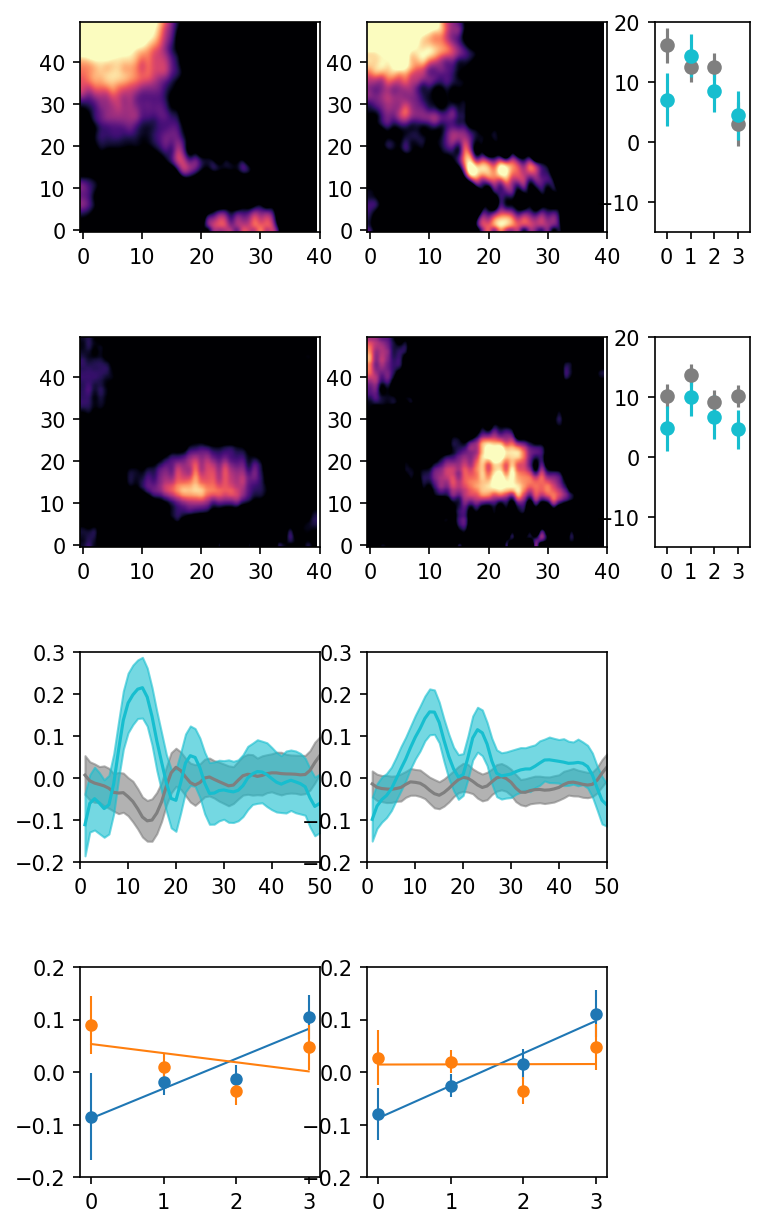

In [21]:
# Create figure
fig = plt.figure(figsize=(7, 10), dpi=150)

# Create GridSpec object with spacing between the plots
gs = gridspec.GridSpec(4, 6, figure=fig)

# Create individual axes
d_single_coh = fig.add_subplot(gs[0, 0:2])  
d_double_coh = fig.add_subplot(gs[0, 2:4]) 
d_lags = fig.add_subplot(gs[0, 4])

k_single_coh = fig.add_subplot(gs[1, 0:2])  
k_double_coh = fig.add_subplot(gs[1, 2:4]) 
k_lags = fig.add_subplot(gs[1, 4])


d_all_coh = fig.add_subplot(gs[2, 0:2]) 

k_all_coh = fig.add_subplot(gs[2, 2:4]) 

d_states = fig.add_subplot (gs[3, 0:2])
k_states = fig.add_subplot (gs[3, 2:4])

gs.update(wspace=0.5, hspace=0.5)


# now actually plot
d_single_coh.imshow(d_ex_coh1, aspect='auto', origin='lower', vmin=0, vmax=.3, interpolation='bicubic', cmap='magma')
d_single_coh.set_xticks((0, 10, 20, 30, 40))
d_double_coh.imshow(d_ex_coh2, aspect='auto', origin='lower', vmin=0, vmax=.3, interpolation='bicubic', cmap='magma')
d_double_coh.set_xticks((0, 10, 20, 30, 40))

k_single_coh.imshow(k_ex_coh1, aspect='auto', origin='lower', vmin=0, vmax=.3, interpolation='gaussian', cmap='magma')
k_single_coh.set_xticks((0, 10, 20, 30, 40))
k_double_coh.imshow(k_ex_coh2, aspect='auto', origin='lower', vmin=0, vmax=.3, interpolation='gaussian', cmap='magma')
k_double_coh.set_xticks((0, 10, 20, 30, 40))

freqs = np.arange(len(k_coh1_means))+1
d_all_coh.fill_between(freqs, d_coh1_means - d_coh1_ci, d_coh1_means + d_coh1_ci, alpha = .6, color='tab:gray')
d_all_coh.fill_between(freqs, d_coh2_means - d_coh2_ci, d_coh2_means + d_coh2_ci, alpha = .6, color='tab:cyan')
d_all_coh.plot(freqs, d_coh1_means, color='tab:gray')
d_all_coh.plot(freqs, d_coh2_means, color='tab:cyan')
d_all_coh.set_ylim((-.2, .3))
d_all_coh.set_xticks((np.arange(0, len(freqs)+1, 10)))
d_all_coh.set_xlim((0, 50))

k_all_coh.fill_between(freqs, k_coh1_means - k_coh1_ci, k_coh1_means + k_coh1_ci, alpha = .6, color='tab:gray')
k_all_coh.fill_between(freqs, k_coh2_means - k_coh2_ci, k_coh2_means + k_coh2_ci, alpha = .6, color='tab:cyan')
k_all_coh.plot(freqs, k_coh1_means, color='tab:gray')
k_all_coh.plot(freqs, k_coh2_means, color='tab:cyan')
k_all_coh.set_ylim((-.2, .3))
k_all_coh.set_xticks((np.arange(0, len(freqs)+1, 10)))
k_all_coh.set_xlim((0, 50))

d_lags.errorbar(np.arange(4), sacc1_f_means[0:4], sacc1_f_cis[0:4], marker='o', linestyle='none', color='tab:gray')
d_lags.errorbar(np.arange(4), sacc2_f_means[0:4], sacc2_f_cis[0:4], marker='o', linestyle='none', color='tab:cyan')
d_lags.set_ylim((-15, 20))
d_lags.set_xlim((-.5, 3.5))
d_lags.set_xticks((0,1,2,3))

k_lags.errorbar(np.arange(4), sacc1_f_means[4:8], sacc1_f_cis[4:8], marker='o', linestyle='none', color='tab:gray')
k_lags.errorbar(np.arange(4), sacc2_f_means[4:8], sacc2_f_cis[4:8], marker='o', linestyle='none', color='tab:cyan')
k_lags.set_ylim((-15, 20))
k_lags.set_xlim((-.5, 3.5))
k_lags.set_xticks((0,1,2,3))

# now plot the relationship between numbers of states and alpha coherence
xt2 = np.arange(4)
slopes = np.mean(b_slopes, axis=0)
intercepts = np.mean(b_ints, axis = 0)
d_states.plot(xt2, (xt2*slopes[1]) + intercepts[1], color='tab:blue', linewidth=1)
d_states.plot(xt2, (xt2*slopes[3]) + intercepts[3], color='tab:orange', linewidth=1)
d_states.errorbar(xt2, coh_by_n_state_means[:,1], coh_by_n_state_cis[:,1], 
                  marker='o', linestyle='none', color = 'tab:blue', markersize=5, linewidth=1)
d_states.errorbar(xt2, coh_by_n_state_means[:,3], coh_by_n_state_cis[:,3], 
                  marker='o', linestyle='none', color = 'tab:orange', markersize=5, linewidth=1)

d_states.set_ylim((-.2, .2))
d_states.set_xticks(xt2)

k_states.plot(xt2, (xt2*slopes[0]) + intercepts[0], color='tab:blue', linewidth=1)
k_states.plot(xt2, (xt2*slopes[2]) + intercepts[2], color='tab:orange', linewidth=1)
k_states.errorbar(xt2, coh_by_n_state_means[:,0], coh_by_n_state_cis[:,0], 
                  marker='o', linestyle='none', color = 'tab:blue', markersize=5, linewidth=1)
k_states.errorbar(xt2, coh_by_n_state_means[:,2], coh_by_n_state_cis[:,2], 
                  marker='o', linestyle='none', color = 'tab:orange', markersize=5, linewidth=1)
k_states.set_ylim((-.2, .2))
k_states.set_xticks(xt2)

#fig.savefig('Fig4_Coherence.svg')

In [22]:
pg.ttest(lags[k_ix & (bhv['state'] < 3) & (bhv['n_sacc'] == 1)], lags[k_ix & (bhv['state'] < 3) & (bhv['n_sacc'] == 2)], correction=False)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,1.549354,2003,two-sided,0.121455,"[-0.88, 7.53]",0.087331,0.207,0.340632


In [23]:
pg.ttest(lags[d_ix & (bhv['state'] < 3) & (bhv['n_sacc'] == 1)], lags[d_ix & (bhv['state'] < 3) & (bhv['n_sacc'] == 2)], correction=False)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,1.283248,1412,two-sided,0.199616,"[-1.84, 8.82]",0.078848,0.155,0.249609


In [24]:
pg.ttest(lags[k_ix & (bhv['state'] < 3) & (bhv['n_sacc'] <3)], 0)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,12.224346,2007,two-sided,3.383090e-33,"[8.71, 12.04]",0.2728,4.512e+29,1.0


In [25]:
slopes

array([ 0.06168934,  0.05683535,  0.00033515, -0.01737966])